In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
import seaborn as sns
import matplotlib.pyplot as plt

Read data

In [2]:
features_df = pd.read_pickle("data/df_for_predictions.pkl")
filtered_df = features_df[features_df['Exercise'] == "back extension set"]
filtered_df = filtered_df.drop(columns=["Exercise"])

Assign binary pain values (0-low, 1-moderate)

In [3]:
filtered_df['Roland-Morris_binary'] = (filtered_df['Roland-Morris'] >= filtered_df['Roland-Morris'].median()).astype(int)
filtered_df['Oswestry_Index_binary'] = (filtered_df['Oswestry Index'] >= filtered_df['Oswestry Index'].median()).astype(int)
print(filtered_df.shape)

(532, 773)


Make sure week/session IDs are correct

In [4]:
df_copy = filtered_df.copy()
df_copy = df_copy[df_copy['Participant'] != 'Margita']
df_copy = df_copy[~((df_copy['Participant'] == 'Petra') & (df_copy['session_id'] == 5))]

# Loop through each participant and reassign session IDs to [1, 2, 3, 4]
for participant in df_copy["Participant"].unique():
    unique_sessions = sorted(df_copy[df_copy["Participant"] == participant]["session_id"].unique())
    session_mapping = {original: new for new, original in enumerate(unique_sessions, start=1)}
    df_copy.loc[df_copy["Participant"] == participant, "session_id"] = df_copy.loc[df_copy["Participant"] == participant, "session_id"].map(session_mapping)

# Rapid symptom improvement 
Step 1: Aggregate mean features for each participant and session (week)

Step 2: Rename columns to represent weeks

Step 3: Pivot data to have a single row per participant with week-prefixed features

Step 4: Define the participants for whom therapy was successful

Step 5: Assign values to the `rapid_improvement` column based on the participant name


In [101]:
df_copy = df_copy.drop(columns=['Rep', 'Roland-Morris', 'Oswestry Index', 'Oswestry_Index_binary', 'Roland-Morris_binary'])
aggregated_df = df_copy.groupby(['Participant', 'session_id']).mean().reset_index()

new_columns = {}
for session in aggregated_df['session_id'].unique():
    session_columns = {col: f"week{session}_{col}" for col in aggregated_df.columns if col not in ['Participant', 'session_id']}
    new_columns.update(session_columns)

pivoted_df = aggregated_df.pivot(index='Participant', columns='session_id')
pivoted_df.columns = [f"week{int(col[1])}_{col[0]}" for col in pivoted_df.columns]  
pivoted_df = pivoted_df.reset_index()  

successful_participants = ['Patrik', 'István', 'Flóra', 'Anita']
pivoted_df['rapid_improvement'] = pivoted_df['Participant'].apply(lambda x: 1 if x in successful_participants else 0)
df_copy['rapid_improvement'] = df_copy['Participant'].apply(lambda x: 1 if x in successful_participants else 0)

Prediction using Lasso regression

In [102]:
feature_names = pivoted_df.drop(columns=['Participant', 'rapid_improvement']).columns

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=0, max_iter=1000))
])

# Prepare the data
X = pivoted_df[feature_names].values
y = pivoted_df['rapid_improvement'].values

# Fit the model
pipeline.fit(X, y)

# Get the coefficients for all features
lasso_coefs = pipeline.named_steps['lasso'].coef_.flatten()

# Extract features with non-zero coefficients
selected_features_lasso = feature_names[lasso_coefs != 0]
selected_coefs = lasso_coefs[lasso_coefs != 0]

# Print the selected features
print("Selected Features by Lasso:")
print(selected_features_lasso)

Selected Features by Lasso:
Index(['week4_Right Shoulder x acc_std', 'week1_L3 x vel_abs_min_fft_coeff',
       'week1_Pelvis x ang_vel_sparc', 'week1_Right Shoulder z ang_vel_sparc',
       'week4_Left Shoulder z ang_vel_sparc',
       'week2_Left Shoulder y ang_acc_ldlj_a',
       'week1_Vertical_T8 Lateral Bending ergo_joint_angle_ROM'],
      dtype='object')


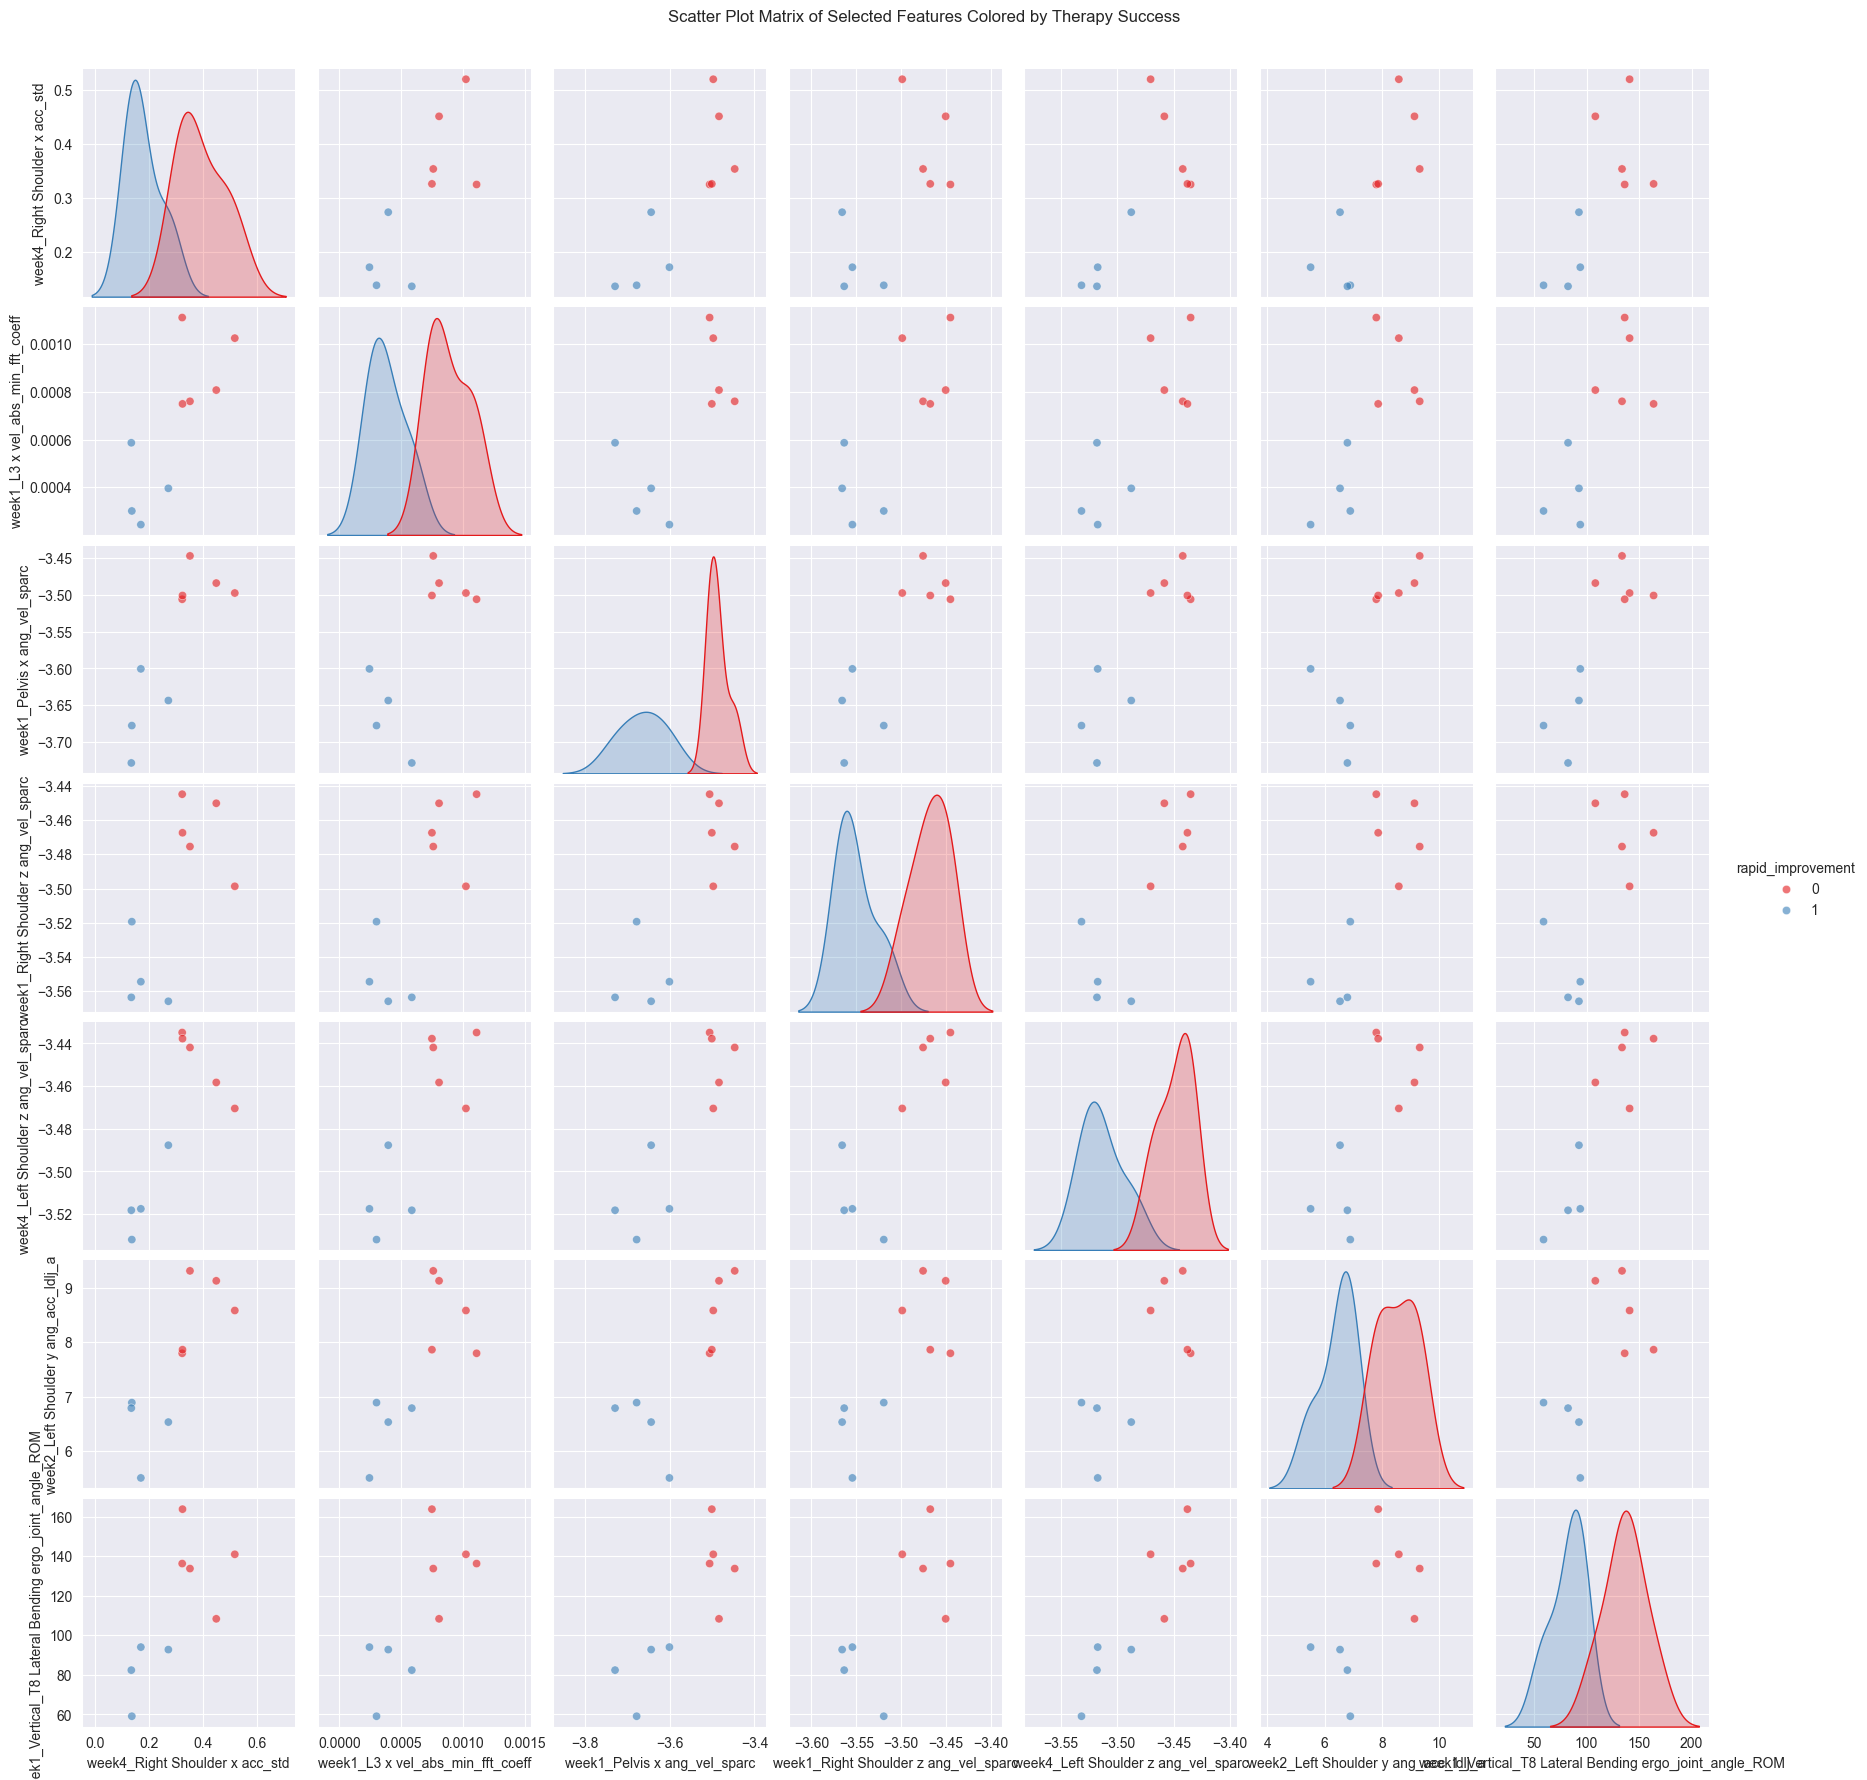

In [103]:
f = selected_features_lasso.tolist()
selected_data = pivoted_df[f + ['rapid_improvement']]

sns.pairplot(
    selected_data,
    hue='rapid_improvement',
    palette="Set1",
    diag_kind="kde",
    plot_kws={'alpha': 0.6}
)
plt.suptitle("Scatter Plot Matrix of Selected Features Colored by Therapy Success", y=1.02)
plt.show()

## Week-by-week evaluation 

The identified features are week-specific - let's see how they perform across all weeks though.

In [104]:
results = []
logo = LeaveOneGroupOut()
selected_features = [
    'Right Shoulder x acc_std', 'L3 x vel_abs_min_fft_coeff',
    'Pelvis x ang_vel_sparc', 'Right Shoulder z ang_vel_sparc',
    'Left Shoulder z ang_vel_sparc', 'Left Shoulder y ang_acc_ldlj_a',
    'Vertical_T8 Lateral Bending ergo_joint_angle_ROM'
]

# Iterate over each session_id
for session_id in df_copy['session_id'].unique():
    print(f"Evaluating for session_id: {session_id}")

    session_df = df_copy[df_copy['session_id'] == session_id]
    X = session_df[selected_features].values  
    y = session_df['rapid_improvement'].values
    groups = session_df['Participant'].values

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=0, max_iter=1000))
    ])

    # Perform Leave-One-Group-Out Cross-Validation (LOGO-CV)
    cv_scores = cross_val_score(pipeline, X, y, cv=logo.split(X, y, groups=groups), scoring='accuracy')

    # Record results
    results.append({
        'session_id': session_id,
        'cv_scores': cv_scores,
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std()
    })

    # Output results for this session_id
    print(f"Session ID {session_id} - LOGO-CV Scores: {cv_scores}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation of Accuracy: {cv_scores.std():.4f}")


print("\nSummary of Results:")
for result in results:
    print(f"Session ID {result['session_id']}:")
    print(f"  Mean Accuracy: {result['mean_accuracy']:.4f}")
    print(f"  Std Accuracy: {result['std_accuracy']:.4f}")

Evaluating for session_id: 1
Session ID 1 - LOGO-CV Scores: [0.83333333 0.91304348 1.         1.         1.         0.9
 0.875      1.         1.        ]
Mean Accuracy: 0.9468
Standard Deviation of Accuracy: 0.0628
Evaluating for session_id: 2
Session ID 2 - LOGO-CV Scores: [0.79166667 1.         0.5        1.         0.84615385 0.875
 0.45454545 0.24       0.6       ]
Mean Accuracy: 0.7008
Standard Deviation of Accuracy: 0.2499
Evaluating for session_id: 3
Session ID 3 - LOGO-CV Scores: [0.63636364 0.85714286 0.1        0.25       1.         0.81818182
 0.22222222 0.         0.42857143]
Mean Accuracy: 0.4792
Standard Deviation of Accuracy: 0.3413
Evaluating for session_id: 4
Session ID 4 - LOGO-CV Scores: [1.         1.         1.         0.85714286 1.         0.88888889
 0.         0.83333333 0.81818182]
Mean Accuracy: 0.8219
Standard Deviation of Accuracy: 0.2997

Summary of Results:
Session ID 1:
  Mean Accuracy: 0.9468
  Std Accuracy: 0.0628
Session ID 2:
  Mean Accuracy: 0.7008


Plot the results

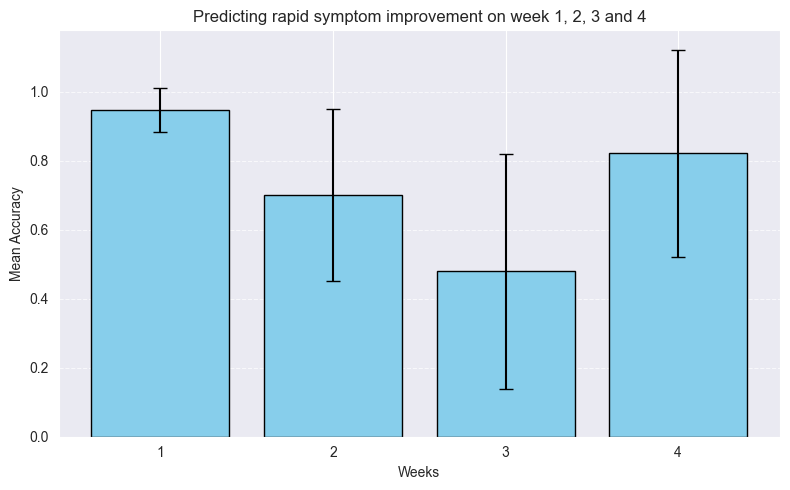

In [105]:
session_ids = [result['session_id'] for result in results]
mean_accuracies = [result['mean_accuracy'] for result in results]
std_accuracies = [result['std_accuracy'] for result in results]

plt.figure(figsize=(8, 5))
plt.bar(session_ids, mean_accuracies, yerr=std_accuracies, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(session_ids)
plt.xlabel("Weeks")
plt.ylabel("Mean Accuracy")
plt.title("Predicting rapid symptom improvement on week 1, 2, 3 and 4")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()